In [1]:
import os
import shutil
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
data_path = './data/mnist_iir_segmentation'
mini_batch_size = 16

In [4]:
# 並べるタイル数
rows=4
cols=4

def make_teacher_image(gen, rows, cols, margin=0):
    source_img  = np.zeros((1, rows*28, cols*28), dtype=np.float32)
    teaching_img = np.zeros((11, rows*28, cols*28), dtype=np.float32)
    for row in range(rows):
        for col in range(cols):
            x = col*28
            y = row*28
            img, label = gen.__next__()
            source_img[0,y:y+28,x:x+28] = img
            teaching_img[label,y:y+28,x:x+28] = img
            teaching_img[10,y:y+28,x:x+28] = (1.0-img)
    teaching_img = (teaching_img > 0.5).astype(np.float32)
    
    # ランダムに反転
    if random.random() > 0.5:
        source_img = 1.0 - source_img
    
    if margin > 0:
        return source_img, teaching_img[:,margin:-margin,margin:-margin]
    return source_img, teaching_img        

def transform_data(dataset, n, rows, cols, margin):
    def data_gen():
        l = len(dataset)
        i = 0
        while True:
            yield dataset[i%l]
            i += 1
    
    gen = data_gen()
    source_imgs = []
    teaching_imgs = []
    for _ in range(n):
        x, t = make_teacher_image(gen, rows, cols, margin)
        source_imgs.append(x)
        teaching_imgs.append(t)
    return source_imgs, teaching_imgs

class MyDatasets(torch.utils.data.Dataset):
    def __init__(self, source_imgs, teaching_imgs, transforms=None):
        self.transforms = transforms
        self.source_imgs = source_imgs
        self.teaching_imgs = teaching_imgs
        
    def __len__(self):
        return len(self.source_imgs)

    def __getitem__(self, index):
        source_img = self.source_imgs[index]
        teaching_img = self.teaching_imgs[index]
        if self.transforms:
            source_img, teaching_img = self.transforms(source_img, teaching_img)
        return source_img, teaching_img

# dataset
dataset_path = './data/'
dataset_train = torchvision.datasets.MNIST(root=dataset_path, train=True, transform=transforms.ToTensor(), download=True)
dataset_test  = torchvision.datasets.MNIST(root=dataset_path, train=False, transform=transforms.ToTensor(), download=True)

# 面積の比率で重み作成
areas = np.zeros((11))
for img, label in dataset_train:
    img = img.numpy()
    areas[label] += np.mean(img)
    areas[10] += np.mean(1.0-img)
areas /= len(dataset_train)

weight = 1. / areas
weight /= np.max(weight)

# フィルタ処理用にタイル化する
dataset_fname = os.path.join(data_path, 'dataset.pickle')
if os.path.exists(dataset_fname):
#if False:
    with open(dataset_fname, 'rb') as f:
        source_imgs_train = pickle.load(f)
        teaching_imgs_train = pickle.load(f)
        source_imgs_test = pickle.load(f)
        teaching_imgs_test = pickle.load(f)
else:
    os.makedirs(data_path, exist_ok=True)
    source_imgs_train, teaching_imgs_train = transform_data(dataset_train, 4096, rows, cols, 0) #29)
    source_imgs_test, teaching_imgs_test = transform_data(dataset_test, 128, rows, cols, 0) #, 29)
    with open(dataset_fname, 'wb') as f:
        pickle.dump(source_imgs_train, f)
        pickle.dump(teaching_imgs_train, f)
        pickle.dump(source_imgs_test, f)
        pickle.dump(teaching_imgs_test, f)

my_dataset_train = MyDatasets(source_imgs_train, teaching_imgs_train)
my_dataset_test = MyDatasets(source_imgs_test, teaching_imgs_test)

loader_train = torch.utils.data.DataLoader(dataset=my_dataset_train, batch_size=mini_batch_size, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset=my_dataset_test, batch_size=mini_batch_size, shuffle=False)

torch.Size([1, 112, 112])
torch.Size([11, 112, 112])


<Figure size 1152x576 with 0 Axes>

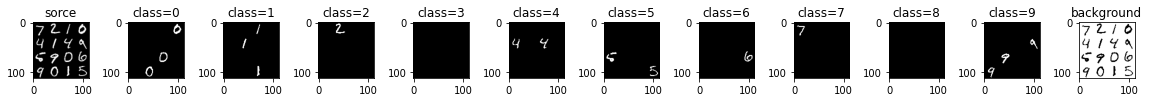

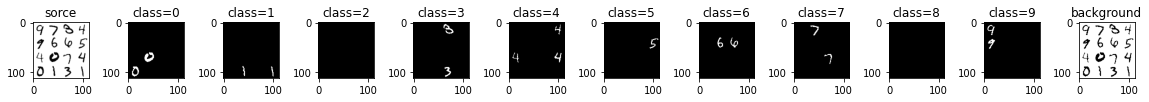

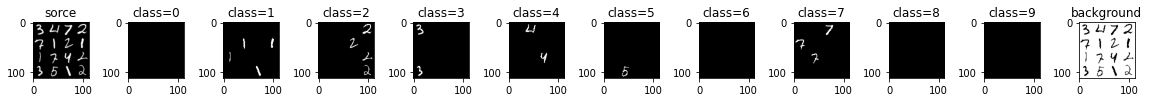

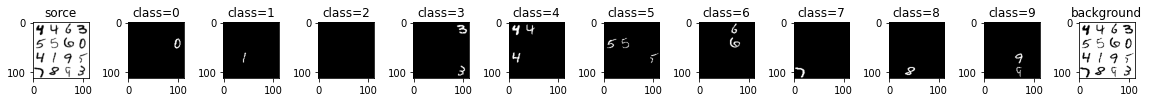

In [5]:
# 学習データ表示確認
def plt_data(x, y):
    plt.figure(figsize=(16,8))
    plt.subplot(1,12,1)
    plt.title('sorce')
    plt.imshow(x[0], 'gray')
    for i in range(11):
        plt.subplot(1,12,2+i)
        if i < 10:
            plt.title('class=%d'%i)
            plt.imshow(y[i], 'gray')
        else:
            plt.title('background')
            plt.imshow(y[i], 'gray')
    plt.tight_layout()
    _ = plt.show()

plt.figure(figsize=(16,8))
for source_imgs, teaching_imgs in loader_test:
    print(source_imgs[0].shape)
    print(teaching_imgs[0].shape)
    for i in range(min(mini_batch_size, 4)):
        plt_data(source_imgs[i], teaching_imgs[i])
    break

In [6]:
class ConvBlock(nn.Module):
    """基本ブロック"""
    def __init__(self, in_ch=64, out_ch=64, act=nn.ReLU(inplace=True)):
        super(ConvBlock, self).__init__()
        self.cnv0  = nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False, padding_mode='replicate')
        self.bn0   = nn.BatchNorm2d(out_ch)
        self.relu0 = nn.ReLU(inplace=True)
        self.cnv1  = nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False, padding_mode='replicate')
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.act   = act
        
    def forward(self, x):
        x = self.cnv0(x)
        x = self.bn0(x)
        x = self.relu0(x)
        x = self.cnv1(x)
        x = self.bn0(x)
        x = self.act(x)
        return x

class Net(nn.Module):
    """IIRフィルタっぽいU-Netもどき"""
    def __init__(self):
        super(Net, self).__init__()
        
        self.ch    = 32
        self.depth = 4
        self.pool  = nn.MaxPool2d(2, 2)
        self.up    = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # 等倍用
        self.m_cnv0 = ConvBlock(1 + self.ch, self.ch)
        self.m_cnv1 = ConvBlock(self.ch, 11, nn.Softmax2d())
        
        # ミップマップ用
        self.s_cnv0 = ConvBlock(2*self.ch, self.ch)
        self.s_cnv1 = ConvBlock(2*self.ch, self.ch)
        
        
    def forward(self, x):
        n = x.shape[0]
        c = x.shape[1]
        h = x.shape[2]
        w = x.shape[3]
        
        # mipmap作成
        mipmap = []
        for i in range(self.depth):
            h //= 2
            w //= 2
            mipmap.append(torch.zeros(n, self.ch, h, w).to(device))
        
        # フィルタ効果が出るまで何回かループする
        for loop in range(3):
            # ミップマップの一番大きいものと concatして推論
            y = self.m_cnv0(torch.cat([x, self.up(mipmap[0])], 1))
            x0 = self.pool(y)
            y = self.m_cnv1(y)
            
            # ミップマップの上下階層をconcatしてそれぞれ同じネットで推論
            for i in range(self.depth):
                if i+1 < self.depth:
                    x1 = self.s_cnv0(torch.cat([mipmap[i], self.up(mipmap[i+1])], 1))
                else:
                    x1 = self.s_cnv0(torch.cat([mipmap[i], mipmap[i]], 1)) # 最下層
                mipmap[i] = self.s_cnv1(torch.cat([x1, x0], 1))
                x0 = self.pool(x1)
        return y

# ネット生成
net = Net().to(device)

In [ ]:
# 面積に応じて重み付けする
w = torch.from_numpy(weight.astype(np.float32)).clone().to(device)
criterion = nn.CrossEntropyLoss(weight=w)

# 学習実施
epochs = 4
optimizer = optim.Adam(net.parameters(), lr=0.001)
for epoch in range(epochs):
    with tqdm(loader_train) as tqdm_loadr:
        for x, t in tqdm_loadr:
            x = x.to(device)
            t = t.to(device).long()
            optimizer.zero_grad()
            y = net(x)
            loss = criterion(y, torch.argmax(t, dim=1))
            loss.backward()
            optimizer.step()
            tqdm_loadr.set_postfix(loss=loss.item())

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

In [ ]:
# 結果表示
with torch.no_grad():
    for x, t in loader_test:
        x = x.to(device)
        t = t.to(device)
        x = F.softmax(net(x), dim=1)
        break

x = x.to('cpu')
for i in range(8):
    plt.figure(figsize=(16, 6))
    for j in range(11):
        plt.subplot(1,11,j+1)
        plt.title('class=%d'%j)
        plt.imshow(x[i][j], 'gray')
    plt.tight_layout()
    plt.show()